# Assignment 1: Hydraulic flow over a weir

Here we will examine many aspects of flow over a weir.  You will need a python environment that has numpy, scipy, matplotlib, ipympl, tqdm, netcdf4 and xarray installed.  

As of 15 Jan this is preliminary.  The last question (Q4) in particular is subject to change.  

For hints on using xarray and netCDF files, please see https://jklymak.github.io/Eos431Phy441/computing/analyze_veros.html#netcdf-and-xarray, and feel free to ask questions.  However, it is almost alwats the same as using numpy, just data sets are stored as one structure.


In [323]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
%matplotlib ipympl

from sve_hybrid import run_modelFVM

## Q1: setup:

Run the model as below.  Note that it will take a while, depending on the speed of your machine.  

This model solves the shallow-water equations in 1-D.  There is a 25-m long channel, with a 0.2-m high, 1.6-m half-width Gaussian bump at $x=10\ \mathrm{m}$ (`zb` below.).  The channel is a constanty 1-m wide (`b`).  The flow starts of with 0 velocity transport (`Q = np.zeros(nx)`).  The left (upstream) side of the channel starts with a height of $0.13\ \mathrm{m}$, and the right (downstream) side with a height of $0.33\ \mathrm{m}$.  

The boundary condition on the right side is that the resevoir depth cannot change (eg, $h(x=25) = 0.33$, but the flow rate can be whatever we want.).  On the left side ($x=0\ \mathrm{m}$), the depth can be any value, but the flow rate is always a constant $Q_{up} = 0.18\ \mathrm{m^3\,s^{-1}}$.  The model has a harmonic diffusion of both $Q$, the flow rate,  and $A$ the cross sectional area of the flow.  

The model returns a matrix of $A(t, x)$ and $Q(t,x)$, saved every `saveT` timesteps, with each row representing a time step.  So `A[10,:]` is $A(t=10^4\,\delta t, x)$ the 10th saved timestep.  

Note because the simulation takes a while, it is a good idea to save the data, and then only run the model again if you need to. I strongly prefer `xarray` for saving data like this, as the data is all in one file, and has dimensions attached for clarity.

0.18


Running model:   5%|▌         | 784/15000 [00:00<00:01, 7832.63it/s]

upstream subcritical
upstream subcritical


Running model: 100%|██████████| 15000/15000 [00:01<00:00, 9034.93it/s]


<xarray.Dataset> Size: 611kB
Dimensions:  (x: 250, time: 151)
Coordinates:
  * x        (x) float64 2kB 0.0 0.1 0.2 0.3 0.4 ... 24.5 24.6 24.7 24.8 24.9
  * time     (time) float64 1kB 0.0 1.0 2.0 3.0 4.0 ... 147.0 148.0 149.0 150.0
Data variables:
    A        (time, x) float64 302kB 0.13 0.13 0.13 0.13 ... 0.0 0.0 0.0 0.0
    Q        (time, x) float64 302kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    zb       (x) float64 2kB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    b        (x) float64 2kB 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    Qup      float64 8B 0.18
    Adown    float64 8B 0.33
Attributes:
    description:  Made with run_modelFVM(nTimes, saveT, dt, dx, zb, b, A, Q, ...

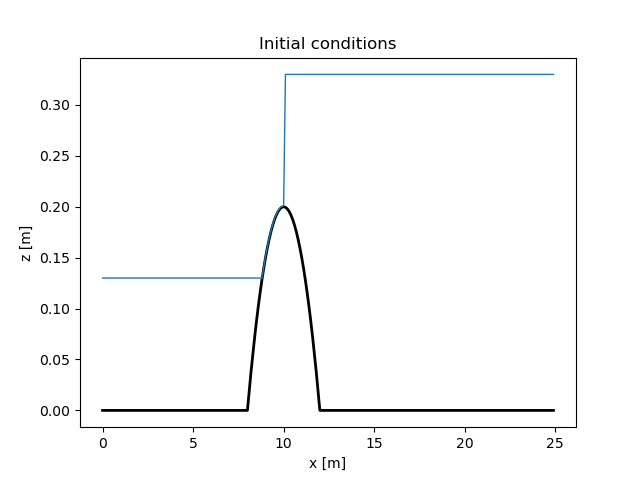

In [337]:
# Case 3 transcritical bump
nTimes = 15_000
saveT = 100
dt = 0.01
time = np.arange(0, dt*nTimes+1, saveT*dt)

dx = 0.1   # m 
nx = 250 
x = np.arange(0, dx*nx, dx)
#x = x
# width:
b = np.ones(nx)  # width in m.

Manning = 0.0014 + 0*b # friction
Manning = 0.0 * Manning
# Manning[:30] = 0
drylim = 1e-10

# Bottom
zb = np.zeros(nx)
zb[(x>=8.0) & (x<=12)] = 0.2 - 0.05*(x[(x>=8.0) & (x<=12)]-10)**2
#zb = 0.2*np.exp(-((x-10)/1.6)**2)

# initial height
h = 0.13 - zb
h[x>10] = 0.33 - zb[x>10]
A = h * b
drylim=1e-3

# inital flow
Qup = 0.18
u0 = Qup / A[0]
print(Qup)

Q = np.zeros(nx) + 0* u0*A # Flow rate m^3/s
#Q = np.zeros(nx) + Qup # Flow rate m^3/s

Q[(A/b)<drylim] = 0.0
A[(A/b)<drylim]= drylim * b[(A/b)<drylim]


if True:
    saveA, saveQ = run_modelFVM(nTimes, saveT, dt, dx, zb, b, A, Q, Qup=Qup, Aup=None, 
                         kappa=0*3e-1/16, 
                         K4=10e-5, Manning=Manning, drylim=drylim, Adown=A[-1])
    #saveA, saveQ = run_modelFVM(nTimes, saveT, dt, dx, zb, b, A, Q, Qup=Qup, Aup=None, 
    #                            kappa=.5e-1/16, Manning=0.0 * b, drylim=drylim, Adown=A[-1])

    # Save the model output to a netcdf file.  
    ds = xr.Dataset(coords={'x':x, 'time':time})
    ds.attrs['description'] = 'Made with run_modelFVM(nTimes, saveT, dt, dx, zb, b, A, Q, Qup=Qup, Aup=None, kappa=0, A4=1e-4, Manning=0.0 * b, drylim=drylim, Adown=A[-1])'
    ds['x'].attrs['description'] = 'x [m]'
    ds['time'].attrs['description'] = 'time [s]'
    ds['A'] = (('time', 'x'), saveA)
    ds['A'].attrs['description'] =  'Cross-sectional area [m^2]'
    
    ds['Q'] = (('time', 'x'), saveQ)
    ds['Q'].attrs['description'] =  'Flow rate [m^3/s]'
    
    ds['zb'] = (('x'), zb)
    ds['zb'].attrs['description'] =  'topography [m]'
    ds['b'] = (('x'), b)
    ds['b'].attrs['description'] =  'channel width [m]'
    ds['Qup'] = ((), Qup)
    ds['Qup'].attrs['description'] =  'upstream forcing [m^3/s]'
    ds['Adown'] = ((), A[-1])
    ds['Adown'].attrs['description'] =  'downstream reservoir cross section [m^2]'
    ds.to_netcdf('ModelRunAssign01_01B.nc')
else: 
    ds = xr.open_dataset('ModelRunAssign01_01B.nc')
fig, ax = plt.subplots()
ax.plot(ds.x, ds.zb, linewidth=2, color='k')
ax.plot(ds.x, ds.zb+ds.sel(time=0).A, linewidth=1, color='C0')
ax.set(xlabel='x [m]', ylabel='z [m]', title='Initial conditions')
display(ds)

### Q1.1 Plot

Plot the raw data versus x.  I like plotting all of it, and then highlighting the initial and final conditions with a thicker line.  Note that while the model returns $A$ you probably want to plot $z+h$, the height of the free surface.  However, I usually prefer plotting $Q$ rather than $u$.

Please label your plots!

Text(0.5, 0, 'x [m]')

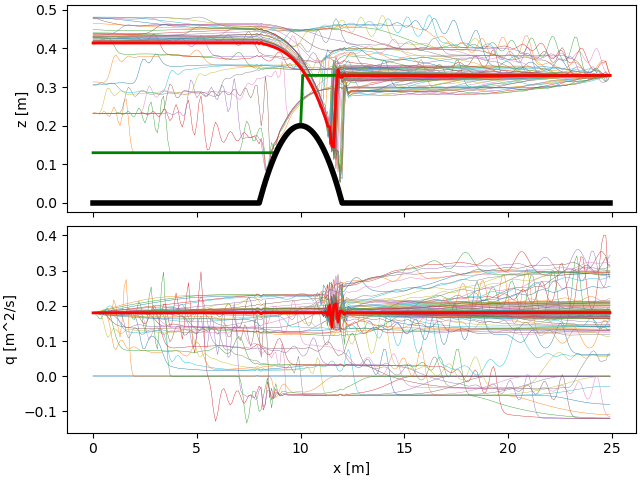

In [325]:
fig, axs = plt.subplots(2, 1, layout='constrained', sharex=True)
ax = axs[0]
ax.plot(ds.x,(ds.A+ds.zb).T, lw=0.3);
ax.plot(ds.x,(ds.A[0, :]+ds.zb).T, 'g', lw=2);
ax.plot(ds.x,(ds.A[-2, :]+ds.zb).T, 'r', lw=2);
ax.plot(ds.x,ds.zb, 'k', lw=4);
ax.set_ylabel('z [m]')
ax = axs[1]

ax.plot(ds.x,(ds.Q).T, lw=0.3);
ax.plot(ds.x,(ds.Q[-2, :]).T, 'r', lw=2);
ax.set_ylabel('q [m^2/s]')
ax.set_xlabel('x [m]')

### Q1.2 Hovmoller diagram

It is also often useful in fluid mechanics to plot a Hovmoller diagram.  this is your quantity of interest colored by value, versus $x$ and $t$ (eg use `pcolormesh`)

<>:9: SyntaxWarning: invalid escape sequence '\ '
<>:9: SyntaxWarning: invalid escape sequence '\ '
/var/folders/kx/4c3bx_w92t31pqyvg6ws03200000gn/T/ipykernel_9739/2577207105.py:9: SyntaxWarning: invalid escape sequence '\ '
  fig.colorbar(pc, ax=ax, location='bottom', label='$q\ \mathrm{[m^2\,s^{-1}]}$')


Text(0.5, 0, 'x [m]')

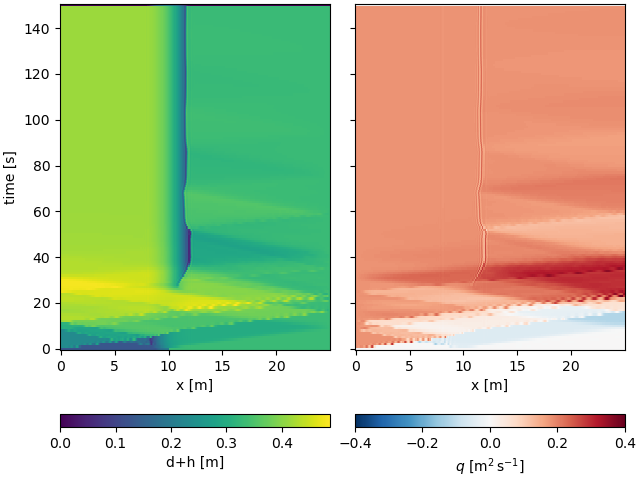

In [326]:
fig, axs = plt.subplots(1, 2, layout='constrained', sharex=True, sharey=True)
ax = axs[0]
pc = ax.pcolormesh(ds.x, ds.time, ds.A+ds.zb)
fig.colorbar(pc, ax=ax, location='bottom', label='d+h [m]')
ax.set_xlabel('x [m]')
ax.set_ylabel('time [s]')
ax = axs[1]
pc = ax.pcolormesh(ds.x, ds.time, ds.Q, cmap='RdBu_r', clim=(-0.4, 0.4))
fig.colorbar(pc, ax=ax, location='bottom', label='$q\ \mathrm{[m^2\,s^{-1}]}$')
ax.set_xlabel('x [m]')

### Q1.3 Describe

Very briefly describe the stages of simulation, perhaps extract a few time slices to make your point. 

Note `dd = ds.sel(time=10, method='nearest')` will return a new dataset `dd` that only has one time in it, at the closest time to 10 s that exists in `ds`

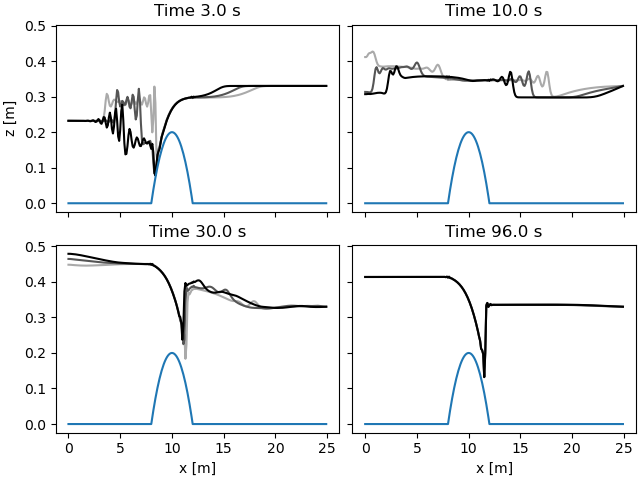

In [327]:
times = [3, 10, 30, 96]
fig, axs = plt.subplots(2, 2, layout='constrained', sharex=True, sharey=True)
for nn in range(len(times)):
    ax = axs.flat[nn]
    for mm in range(2, -1, -1):
        dd = ds.sel(time=times[nn]+mm, method='nearest')
        ax.plot(dd.x, dd.A+dd.zb, color=f'{mm/3}')
    ax.plot(dd.x, dd.zb)
    dd = ds.sel(time=times[nn], method='nearest')
    ax.set_title(f'Time {dd.time.values} s')
    if nn>1:
        ax.set_xlabel('x [m]')
    if nn ==0:
        ax.set_ylabel('z [m]')
    

Early in the simulation, the flow from the left has not had a chance to matter very much, and the dominant flow is the high water level on the right pushing over the obstacle.  A hydraulic jump forms on the left side of the obstacle.  

As time progresses, the flow from the left creates a reflecting series of waves that push the left basin water level over the crest of the sill (time=10s).  This arrest the flow to the lef and the flow starts being towards the right. 

This adjustment continues for quite a while, and indeed the water level in the left reservoir gets deeper than its steady state as it works to reverse the flow at the obstacle (30 s) 

Eventually this water is pushed downstream and a approximate steady state is reached (96 s). The Hovmoller diagram indicates that this is approximately in steady state after 90 s, though we should really run the simulation even longer to be sure.  

## Q2: Compare with theory

Lets consider the last good simulation step and see if our steady theory works.

### Q2.1 does solution conserve mass?

How well does the solution conserve mass? Rember that any transport convergence must show up as vertical change in the surface height.

[Text(0.5, 0, 'x [m]'), Text(0, 0.5, 'dQ/dx')]

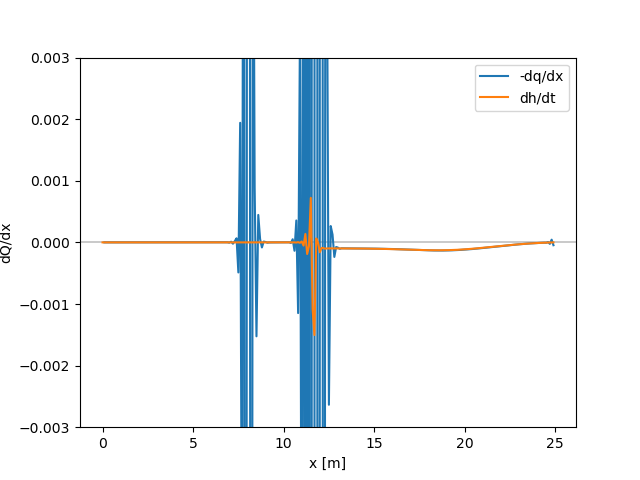

In [328]:
ddm1 = ds.isel(time=-4)
dd0 = ds.isel(time=-3)
ddp1 = ds.isel(time=-2)
dd = dd0
fig, ax = plt.subplots()
ax.axhline(0, color='k', linewidth=0.3)
ax.plot(dd.x[1:], -np.diff(dd0.Q)/np.diff(dd.x), label='-dq/dx')
ax.set_ylim([-0.003, 0.003])

ax.plot(dd.x, (ddp1.A-ddm1.A)/(ddp1.time-ddm1.time), label='dh/dt')
ax.legend()
ax.set(xlabel='x [m]', ylabel='dQ/dx')

The solution does a pretty reasonable job of conserving mass.  There is a positive and negative anomally over the topography, and downstream of the hydraulic jump.  These can be reduced by increasing the spatial resolution and reducing the artificial diffusion.

Note that the flow downstream of the bump is not in perfect steady state yet.  

### Q2.1 plot Froude number

Compute the value of the Froude number as a function of x, and describe how it conforms (or not) to our expectations.

(6.0, 15.0)

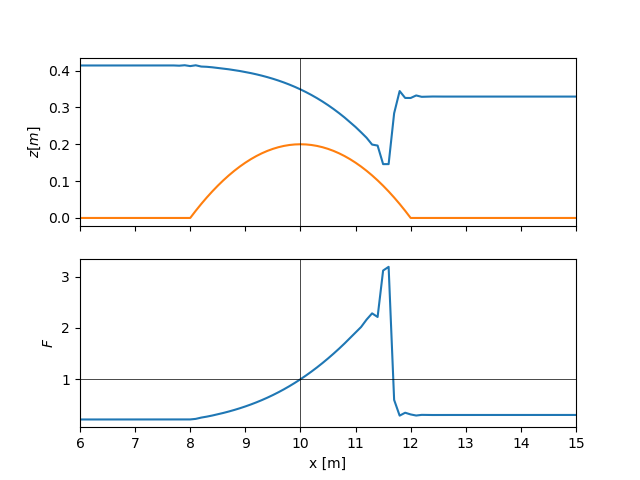

In [329]:
g = 9.81
dd['Fr'] = np.sqrt(dd['Q']**2/g/dd['A']**3)

fig, axs = plt.subplots(2, 1, sharex=True)
ax = axs[0]
ax.plot(dd.x, dd.A+dd.zb)
ax.plot(dd.x, dd.zb)
ax.set_ylabel('$z [m]$')
ax.axvline(10, color='k', lw=0.5)
ax = axs[1]
ax.plot(dd.x, dd.Fr)
ax.axvline(10, color='k', lw=0.5)
ax.axhline(1, color='k', lw=0.5)
ax.set_ylabel('$F$')
ax.set_xlabel('x [m]')
ax.set_xlim(6, 15)


The Froude number is subcritical upstream of the obstacle crest.  It is _very_ close to 1 at the obstacle crest.  Note that it is supercritical until the hydraulic jump, where it transitions back to subcritical. 

### Q2.3 Compare flow crosssection with theory

Given $q=0.18\ \mathrm{m^2\,s^{-1}}$ and $h(x)$ we can calculate the flow everywhere upstream of the hydraulic jump.  See how well the flow does comapred to the theoretical prediction.  Note there is a root finding exercise here, and there are multiple roots at each value of $h(x)$

(6.0, 14.0)

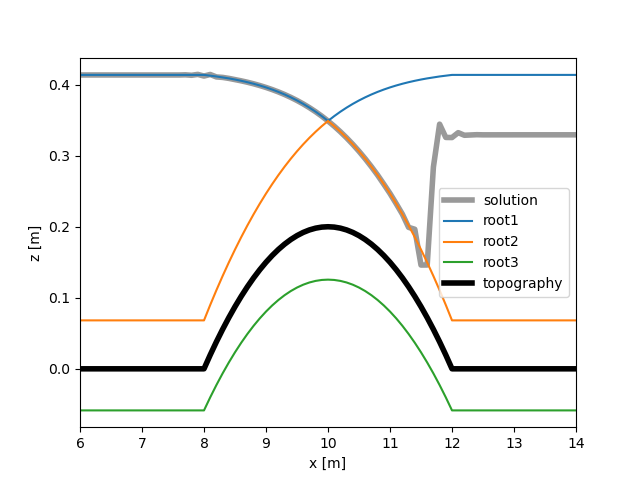

In [330]:
# at the sill crest Fr = 1, q = 0.18, so 
dc = (dd.Qup**2/g)**(1/3)
uc = dd.Qup / dc
Bc = 0.5*uc**2 + g * (dc + np.max(dd.zb.values))
# now we just need to solve B = 0.5 (q^2/d^2) + g*(d+b) everywhere for d, with everything else being 
# a constant
htheory = np.zeros((3, len(dd.x)))
for i in range(len(dd.x)):
    coefficients = [g, g*dd.zb[i]-Bc, 0, 0.5*dd.Qup**2]
    roots = np.roots(coefficients)
    htheory[:, i] = roots

fig, ax = plt.subplots()
ax.plot(dd.x, dd.A+dd.zb, label='solution', lw=4, color='0.6')
ax.plot(dd.x, (htheory+dd.zb.values).T, label=['root1', 'root2', 'root3'])
ax.plot(dd.x, dd.zb, color='k', linewidth=4, label='topography')
ax.legend()
ax.set(xlabel='x [m]', ylabel='z [m]')
ax.set_xlim(6, 14)

So, the solution is very close to the theory upstream of the hydraulic jump.  Note that at the sill crest the cubic solutions share a root and the actual solution _switches_ from the larger root where the flow is subcritical to the smaller of the positive roots when it is supercritical.  The negative root is, of course, a-physical.  There is a hydraulic jump, as expected as the subcritical flow must match with the crest flow.  

### Q2.4 Check Bernoulli function is constant

Show that the Bernoulli function at the surface ($z=h+d$) is approximately constant and comment on where it is not.  Also argue that the Bernoulli function has the same value at $z=h(x)$

<>:6: SyntaxWarning: invalid escape sequence '\ '
<>:6: SyntaxWarning: invalid escape sequence '\ '
/var/folders/kx/4c3bx_w92t31pqyvg6ws03200000gn/T/ipykernel_9739/3463682136.py:6: SyntaxWarning: invalid escape sequence '\ '
  ax.set(xlabel='x [m]', ylabel='$B\ \mathrm{[m^2\,s^{-1}]}$')


[Text(0.5, 0, 'x [m]'), Text(0, 0.5, '$B\\ \\mathrm{[m^2\\,s^{-1}]}$')]

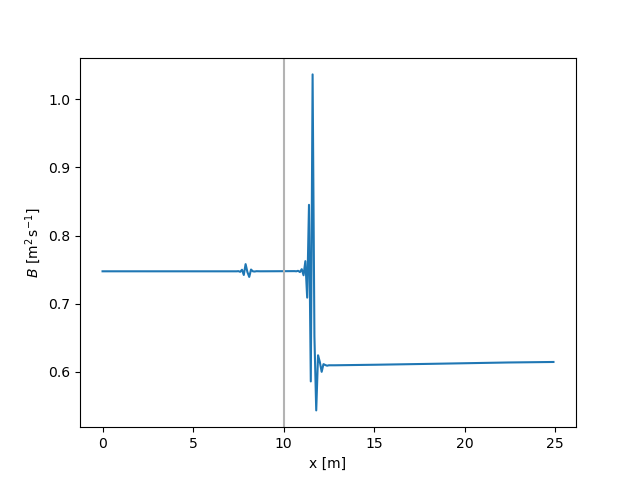

In [331]:
dd['u'] = dd.Q / dd.A
B = 0.5 * (dd.u)**2 * dd.A  + g * (dd.zb + dd.A) * dd.A
fig, ax = plt.subplots()
ax.plot(ds.x, B * dd.u)
ax.axvline(10, color='0.7')
ax.set(xlabel='x [m]', ylabel='$B\ \mathrm{[m^2\,s^{-1}]}$')


The Bernoulli function is constant except in the hydraulic jump and appears to have some contibues drop in the downstream reservoir.

The Bernoulli function is 

$$ B = \frac{1}{2}u^2 + gz + P/\rho$$

At $z=d+h$ we have $P=P_{atm}$, so $B(z=h+d) = \frac{1}{2}u^2 + gd + gh + P_{atm}$.  

At $z = h$ we have $P = P_{atm} + g d$, so $B(z=h) = \frac{1}{2}u^2 + gd + gh + P_{atm}$. 

Note that these would not necessarily be the same if the density varied with depth.  

### Q2.5 Check that energy is conserved

Consider the terms of the vertically integrated energy budget, and show where they balance and discuss where they do not.  Be sure to show how you derived the terms, and note the units and how they relate to Joules or Watts.  What is the rate that energy is being lost in the hydraulic jump?  How much energy is lost total in the system:

In steady state, the energy budget says

$$ \frac{\partial}{\partial x}\int_{h}^{h+d} u(E + P) dz = dissipation / distance $$, and this we expect the integral to be approximately constant.  The integral can be evaluated as:

$$ u \int_{h}^{h+d}\left( \frac{1}{2}u^2 + gz + P\right)\, \mathrm{d}z  $$

which we break into kinetic energy transport, potential energy transport and pressure work:

$ KE = Q \frac{1}{2}u^2$

$PE = u g \frac{1}{2} z^2 |_h^{h+d} = Qg\left(\frac{d}{2} + h\right)$

$PW = u g \int_0^d g z \ \mathrm{d}z = Qg \frac{d}{2}$

The units of these quantitites are in $m^4\,s^{-3}$.  This is the same as Watts / density of water / width of channel:  $W =J/s = kg\,m \,m\, s^{-2} s^{-1} = kg\, m^2\,s^{-3}$.  So per density per width is $m^4\, s^{-3}$.  We could express as W / m by multiplying the values above by $\rho = 1000 kg\,m^{-3}$.

<xarray.DataArray ()> Size: 8B
array(137.63799446)
Coordinates:
    time     float64 8B 148.0


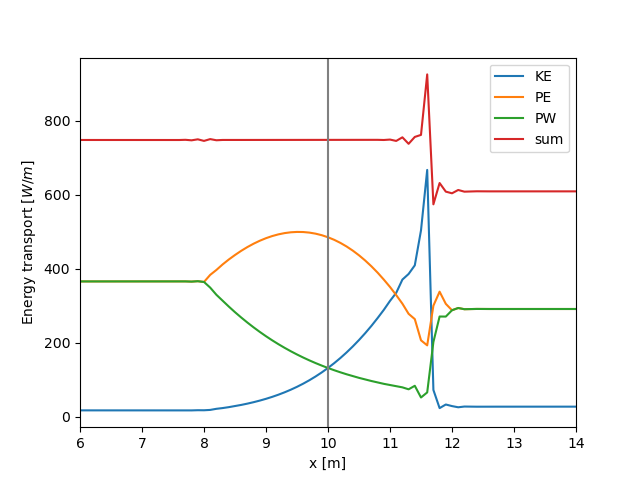

In [332]:
fig, ax = plt.subplots()
KE = 1e3*Qup * 0.5 * dd.u**2
PE = 1e3*Qup * g * (dd.A/2 + dd.zb)
PW = 1e3*Qup * g * (dd.A/2)
ax.plot(ds.x, KE, label='KE')
ax.plot(ds.x, PE, label='PE')
ax.plot(ds.x, PW, label='PW'),
ax.plot(ds.x, KE+PE+PW, label='sum')
ax.legend()
ax.set(xlabel='x [m]', ylabel='Energy transport $[W/m]$')
ax.axvline(10, color='0.5')
ax.set_xlim(6, 14)
print((KE+PE+PW)[0] - (KE+PE+PW)[-2])

The total energy transport plus the pressure work is approximately constant until the hydraulic jump after which it drops.  We see the expected exchange between KE and PE, with KE increasing over the bump, initially at the expense of pressure work (note the PE increases over the bump until the obstacle crest), and then at the expense of the potential energy and pressure work.  

The hydraulic jump loses energy in the drop from 750 W/m to 621 W/m = 129 W/m.  

Total energy loss is approximately 138 W/m, though we should check for energy rate of change as well!


### Q2.6 Figure out the jump location

There is clearly a hydraulic jump on the topography.  We can figure out its location by noting that the Bernoulli function is known in the downstream reservoir, in addition to knowing it on the ridge crest.  These Bernoulli functions are constant to the left and right side of the jump, so that gives two equations in three unknowns, $d_{left}$, $d_{right}$, $h(x_j) = h_j$.   A third equation can be derived by conserving the flux of momentum across the hydraulic jump. 

These three equations are pretty non-linear, so I solved using `scipy.optimize.root`, with the three unknowns as the roots. 

Plot the upstream and downstream solutions for d on the same plot, and indicate the location of the hydraulic jump.  


In [333]:
import scipy.optimize as optim

# Downstream Bernoulli
A = 0.5 *Qup**2 / dd.A[-10]**2 + g * dd.A[-10]
dc = dd.sel(x=10, method='nearest').A
hm = np.max(dd.zb)

# Upstream Bernoulli
B = 0.5 *Qup**2 / dc**2 + g * (dc + hm)


def fun(x, *args):
    dm = x[0]
    dp = x[1]
    hj = x[2]
    if dp < dm:
        res = [1e6, 1e6, 1e6]
    elif dp < 0:
        res = [1e6, 1e6, 1e6]
    elif dm < 0:
        res = [1e6, 1e6, 1e6]
    elif hj < 0:
        res = [1e6, 1e6, 1e6]        
    else: 
        res = [Qup**2 / dm**2 - g * dp / 2  *(1 +dp/dm),
                (0.5*Qup**2 / dp**2 + g * (dp+hj)  - A).values ,
                (0.5*Qup**2 / dm**2 + g * (dm+hj)  - B).values 
              ]
    return res

# initial guess
dp = dd.A[-10] 
dm = dc / 18
hj = 0.0
result = optim.root(fun, x0=np.array([dm, dp, hj]), options={'maxiter':10_000, 'xtol':1e-10})
print(result)

 message: The solution converged.
 success: True
  status: 1
     fun: [-3.014e-12  1.041e-12  8.882e-16]
       x: [ 7.594e-02  2.594e-01  6.111e-02]
  method: hybr
    nfev: 30
    fjac: [[-9.286e-01  1.564e-01 -3.365e-01]
           [ 3.491e-01  6.086e-02 -9.351e-01]
           [ 1.257e-01  9.858e-01  1.111e-01]]
       r: [ 1.907e+02  2.313e+01 -1.767e+00 -8.325e+00 -8.576e+00
            1.076e+01]
     qtf: [ 1.006e-09 -3.260e-10  2.095e-10]


/var/folders/kx/4c3bx_w92t31pqyvg6ws03200000gn/T/ipykernel_9739/1608275135.py:35: OptimizeWarning: Unknown solver options: maxiter
  result = optim.root(fun, x0=np.array([dm, dp, hj]), options={'maxiter':10_000, 'xtol':1e-10})


In [334]:
dp = result.x[1]
dm = result.x[0]
hj = result.x[2]


11.666017459859448


/var/folders/kx/4c3bx_w92t31pqyvg6ws03200000gn/T/ipykernel_9739/2042655579.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  htheory2[:, i] = roots


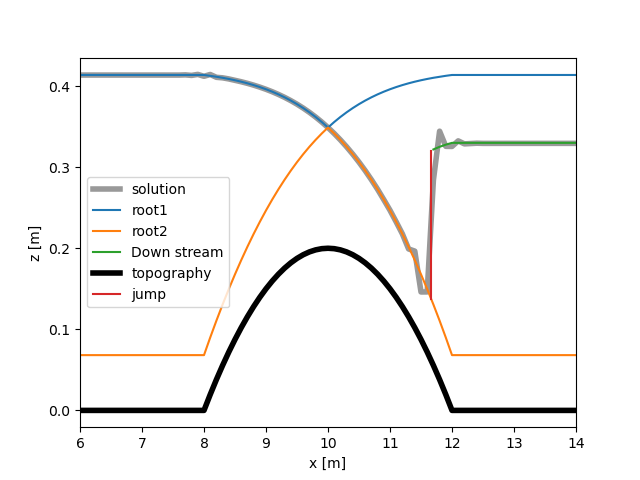

In [241]:
# upstream solutions
dc = (dd.Qup**2/g)**(1/3)
uc = dd.Qup / dc
Bc = 0.5*uc**2 + g * (dc + np.max(dd.zb.values))
# now we just need to solve B = 0.5 (q^2/d^2) + g*(d+b) everywhere for d, with everything else being 
# a constant
xj = np.interp(hj, dd.zb[dd.x>10][::-1], dd.x[dd.x>10][::-1])
print(xj)
htheory = np.zeros((3, len(dd.x)))
for i in range(len(dd.x)):
    coefficients = [g, g*dd.zb[i]-Bc, 0, 0.5*dd.Qup**2]
    roots = np.roots(coefficients)
    htheory[:, i] = roots

# dowstream solution
ddown = dd.Adown
udown = dd.Qup / ddown
Bdown = 0.5*udown**2 + g * (ddown)
# now we just need to solve B = 0.5 (q^2/d^2) + g*(d+b) everywhere for d, with everything else being 
# a constant
htheory2 = np.zeros((3, len(dd.x)))
for i in range(len(dd.x)):
    coefficients = [g, g*dd.zb[i]-Bdown, 0, 0.5*dd.Qup**2]
    roots = np.roots(coefficients)
    htheory2[:, i] = roots

fig, ax = plt.subplots()
ax.plot(dd.x, dd.A+dd.zb, label='solution', lw=4, color='0.6')
ax.plot(dd.x, (htheory[:-1, :]+dd.zb.values).T, label=['root1', 'root2'])
ax.plot(dd.x[x>xj], (htheory2[0, x>xj]+dd.zb.values[x>xj]).T, label='Down stream')
ax.plot(dd.x, dd.zb, color='k', linewidth=4, label='topography')
ax.plot([xj, xj], [hj+dm, hj+dp], label='jump')
ax.set(xlabel='x [m]', ylabel='z [m]')
ax.set_xlim(6, 14)
#ax.axvline(xj)
ax.legend()


Note that the jump is relatively well predicted; the downstream Bernoulli fucntion is not quite correct, and downstream not quite in steady state.  But overall this does a good job of predicting the state of the flow.

## Q3 Run your own version

Run your own version of the simulation, and discuss the results.  There is no need to do all the analyses above, but you might comment if the flow is sub/super critical and where. 

## Q4 Dam break problem and characteristics

Run the following code, and plot a Hovmoller diagram.  

Compare the results to the results using the method of characteristics.  

0.0


Running model:  35%|███▍      | 1039/3000 [00:00<00:00, 5209.10it/s]

upstream subcritical
upstream subcritical


Running model: 100%|██████████| 3000/3000 [00:00<00:00, 5423.75it/s]


<xarray.Dataset> Size: 520kB
Dimensions:  (x: 1000, time: 31)
Coordinates:
  * x        (x) float64 8kB 0.0 0.025 0.05 0.075 0.1 ... 24.9 24.93 24.95 24.98
  * time     (time) float64 248B 0.0 0.25 0.5 0.75 1.0 ... 6.5 6.75 7.0 7.25 7.5
Data variables:
    A        (time, x) float64 248kB 0.33 0.33 0.33 0.33 ... 0.0 0.0 0.0 0.0
    Q        (time, x) float64 248kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    zb       (x) float64 8kB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    b        (x) float64 8kB 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    Qup      float64 8B 0.0
    Adown    float64 8B 0.23
Attributes:
    description:  Made with run_modelFVM(nTimes, saveT, dt, dx, zb, b, A, Q, ...

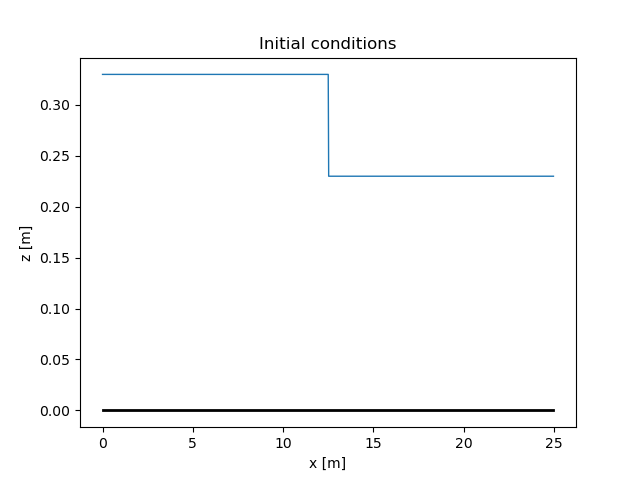

In [338]:
# Case 3 transcritical bump
nTimes = 3_000
saveT = 100
dt = 0.01 / 4
time = np.arange(0, dt*(nTimes+100), saveT*dt)

dx = 0.1 / 4  # m 
nx = 250 * 4
x = np.arange(0, dx*nx, dx)
#x = x
# width:
b = np.ones(nx)  # width in m.

Manning = 0.0014 + 0*b # friction
Manning = 0.0 * Manning
# Manning[:30] = 0
drylim = 1e-10

# Bottom
zb = np.zeros(nx)
#zb[(x>=8.0) & (x<=12)] = 0.2 - 0.05*(x[(x>=8.0) & (x<=12)]-10)**2
#zb = 0.2*np.exp(-((x-10)/1.6)**2)

# initial height
h = 0.33 - zb
h[x>12.5] = 0.23 - zb[x>12.5]
A = h * b
drylim=1e-3

# inital flow
Qup = 0.0
u0 = Qup / A[0]
print(Qup)

Q = np.zeros(nx) + 0* u0*A # Flow rate m^3/s
#Q = np.zeros(nx) + Qup # Flow rate m^3/s

Q[(A/b)<drylim] = 0.0
A[(A/b)<drylim]= drylim * b[(A/b)<drylim]


if True:
    saveA, saveQ = run_modelFVM(nTimes, saveT, dt, dx, zb, b, A, Q, Qup=Qup, Aup=None, 
                         kappa=0*3e-1/16, 
                         K4=20e-5/2**4, Manning=Manning, drylim=drylim, Adown=A[-1])
    #saveA, saveQ = run_modelFVM(nTimes, saveT, dt, dx, zb, b, A, Q, Qup=Qup, Aup=None, 
    #                            kappa=.5e-1/16, Manning=0.0 * b, drylim=drylim, Adown=A[-1])
    time = time[:(len(saveA[:, 0])+1)]
    # Save the model output to a netcdf file.  
    ds = xr.Dataset(coords={'x':x, 'time':time})
    ds.attrs['description'] = 'Made with run_modelFVM(nTimes, saveT, dt, dx, zb, b, A, Q, Qup=Qup, Aup=None, kappa=0, A4=1e-4, Manning=0.0 * b, drylim=drylim, Adown=A[-1])'
    ds['x'].attrs['description'] = 'x [m]'
    ds['time'].attrs['description'] = 'time [s]'
    ds['A'] = (('time', 'x'), saveA)
    ds['A'].attrs['description'] =  'Cross-sectional area [m^2]'
    
    ds['Q'] = (('time', 'x'), saveQ)
    ds['Q'].attrs['description'] =  'Flow rate [m^3/s]'
    
    ds['zb'] = (('x'), zb)
    ds['zb'].attrs['description'] =  'topography [m]'
    ds['b'] = (('x'), b)
    ds['b'].attrs['description'] =  'channel width [m]'
    ds['Qup'] = ((), Qup)
    ds['Qup'].attrs['description'] =  'upstream forcing [m^3/s]'
    ds['Adown'] = ((), A[-1])
    ds['Adown'].attrs['description'] =  'downstream reservoir cross section [m^2]'
    ds.to_netcdf('ModelRunAssign01_02B.nc')
else: 
    ds = xr.open_dataset('ModelRunAssign01_02B.nc')

fig, ax = plt.subplots()
ax.plot(ds.x, ds.zb, linewidth=2, color='k')
ax.plot(ds.x, ds.zb+ds.sel(time=0).A, linewidth=1, color='C0')
ax.set(xlabel='x [m]', ylabel='z [m]', title='Initial conditions')

display(ds)

### Q4.1 Plot the response

- I'd suggest both line plots and a Hovmoller diagram of $d(x, t)$.  Note that it is somewhat useful to plot a Hovmoller diagram of $u(x, t)$ as well.  

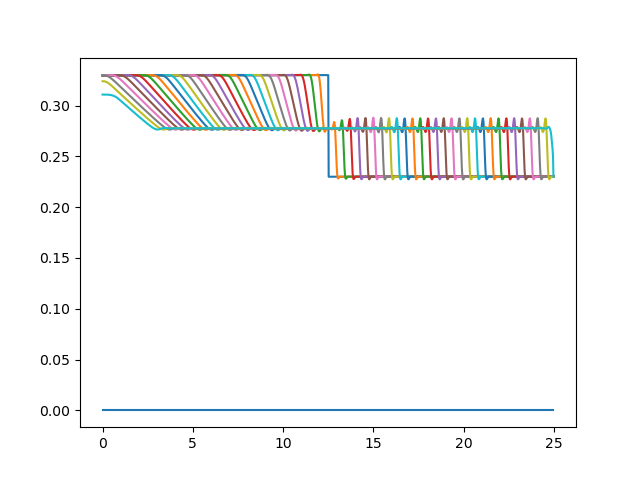

In [321]:
fig, ax = plt.subplots()
ax.plot(x, saveA[:,:].T);

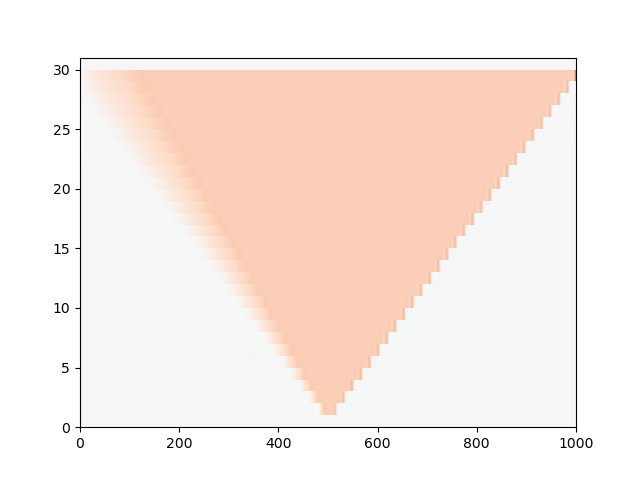

In [342]:
fig, ax = plt.subplots()
ax.pcolormesh(saveQ, vmin=-1/3, vmax=1/3, cmap='RdBu_r')

### Q4.2: Solve for the characterstics numerically

We can iterartively solve for characterstics by 
- defining a grid in x and t (note I made these more finely resolved than the non-linear solution otherwise it is not very accurate)
- From the first time step, propagating the positive and negative characterstics forward in time to the second time step.
- We now know R+, R- at values of x at the next time step, interpolate these onto the x-grid
- now we know R+ and R- on the x-grid so solve for the new $u$ and $d$.
- repeat for the next time step.

Plot the water level as a Hovmoller diagram and compare to your non-linear simulation.  Note the location of any shocks or rarefactions.

Using the solution, calcculate a series of characteristics emanating from the time origin, and discuss how they correspond to the shock or rarefaction.  

In [423]:
# so just use the xgrid and time grid from our saved data...

x = np.arange(ds.x[0], ds.x[-1], 0.01)
t = np.arange(ds.time[0], ds.time[-1], 0.003)

U  = np.zeros((len(t), len(x)))
C  = np.zeros((len(t), len(x)))
D = np.interp(x, ds.x, ds.A[0, :])
C[0, :] = np.sqrt(g*D)

for n in range(1, len(t)):
    dt = t[n] - t[n-1]
    Rpn = U[n-1, :] + 2 * C[n-1, :]
    Rmn = U[n-1, :] - 2 * C[n-1, :]
    
    # positive characteristic
    xpn = x + dt * (U[n-1, :] + C[n-1, :])
    # negative
    xmn = x + dt * (U[n-1, :] - C[n-1, :])

    # carry forward to next grid point
    Rpn = np.interp(x, xpn, Rpn)
    Rmn = np.interp(x, xmn, Rmn)

    U[n, :] = (Rpn+Rmn) / 2
    C[n, :] = (Rpn-Rmn) / 4

# trace some characteristics through this.  
x0 = np.arange(11.5, 13.5,5.0)
x0 = np.concatenate((x0, np.arange(25)))
xp = np.zeros((len(t), len(x0)))
xp[0, :] = x0
xm = np.zeros((len(t), len(x0)))
xm[0, :] = x0
for n in range(1, len(t)):
    dt = t[n] - t[n-1]
    u = np.interp(xp[n-1, :], x, U[n, :]+C[n, :])
    xp[n, :] = xp[n-1, :] + dt * u
    u = np.interp(xm[n-1, :], x, U[n, :]-C[n, :])
    xm[n, :] = xm[n-1, :] + dt * u




(0.0, 25.0)

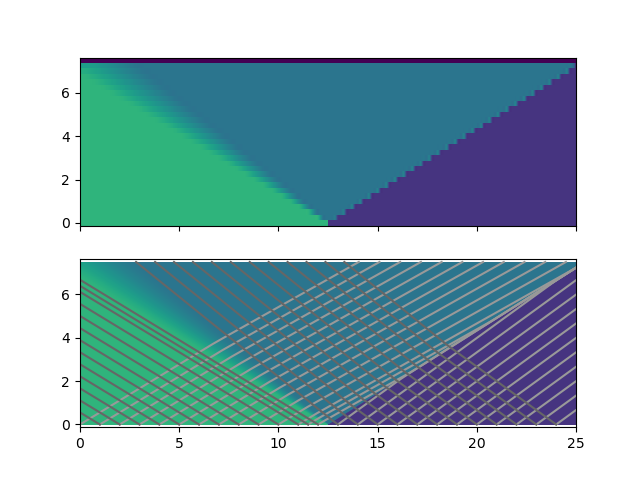

In [424]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
D = C**2/g
ax = axs[0]
ax.pcolormesh(ds.x, ds.time, ds.A, clim=(0.2, 0.4))
ax = axs[1]
ax.pcolormesh(x, t, D, clim=(0.2, 0.4), rasterized=True)
ax.plot(xp[:, ::1], t, color='0.6');
ax.plot(xm[:, ::1], t, color='0.4');
ax.set_xlim([0, 25])

We can see that the characteristics solution and the fully nonlinear solutions have similar results.  The charactrestic lines show that the right-going characteristics converge in the shock, with the characterstics from the left moving faster than the characteristics to the right.  On the left side of the dam break, there is a rarefaction, with the left-going characteristics fanning out. 